# A tensorflow model for Dictionary Filter

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

2024-07-29 18:14:39.577001: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 18:14:39.701379: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 18:14:40.432593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path.append('../Library')

from Metrics.RMSE import RMSE
from Metrics.CrossTab import CrossTab
from Modules.GaussianDF import GaussianDF as DictionaryFilter

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Test on Netflix Full dataset

In [4]:
# Read the dataset
dataset = pd.read_csv('../Data/Netflix/Full/dataset.csv')

# Display the dataset
dataset.head()

,Movie Index,User Index,Rating
0,0,270045,3
1,0,149546,5
2,0,160878,4
3,0,5466,4
4,0,149791,3


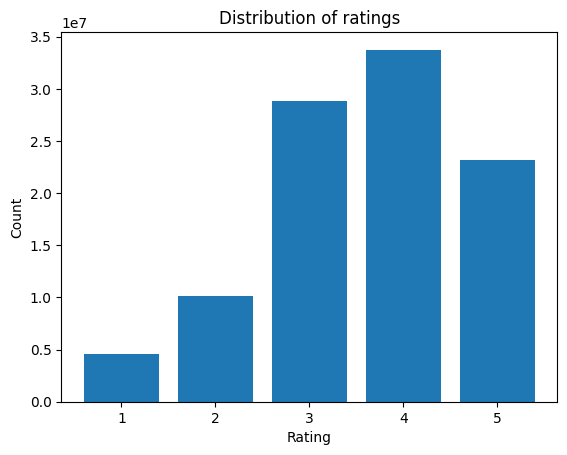

In [5]:
# Plot the distribution of ratings
rating_counts = dataset['Rating'].value_counts().sort_index()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
from AdvancedModelSelection import user_based_train_val_test_split

# Split the dataset into train, validation, and test data
train_data, val_data, test_data = user_based_train_val_test_split(dataset, test_size=0.2, val_size=0.1, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

In [ ]:
NUM_MOVIES = dataset['Movie Index'].max() + 1
NUM_USERS = dataset['User Index'].max() + 1
NUM_FACTORS = 16
BATCH_SIZE = 128
TRAIN_LAMBDA = 2.0
INIT_SCALE = dataset['Rating'].mean() / NUM_FACTORS
NUM_EPOCHS = 20

In [ ]:
# Convert train data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert validation data to sparse tensor
val_sparse_tensor = tf.sparse.SparseTensor(
    indices=val_data[['Movie Index', 'User Index']].values,
    values=val_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
val_sparse_tensor = tf.sparse.reorder(val_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

In [ ]:
# Create dataset
def create_train_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

def create_full_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        test_slices = tf.sparse.split(sp_input=test_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]), tf.sparse.to_dense(test_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

In [ ]:
# Clean up unused memory
del dataset, train_data, val_data, test_data

## Experiments
### 1. Batch size vs train time vs RMSE

In [ ]:
# Initialize variables
batch_sizes = [8, 32, 128, 512]
rmse_train_results = np.zeros((len(batch_sizes), 5))
rmse_val_results = np.zeros((len(batch_sizes), 5))
train_timer = np.zeros((len(batch_sizes)))

for i, batch_size in enumerate(batch_sizes):

    # Create the model
    model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
    rmse_train = RMSE()
    rmse_val = RMSE()

    # Create the dataset
    dataset = create_train_dataset(batch_size)
        
    start_time = time.time()  # Start the timer

    # Train the model
    for epoch in range(5):
        progress_bar = tqdm(total=NUM_USERS // batch_size, desc=f"Epoch {epoch+1}", unit="batch")
        
        for train_batch, val_batch in dataset:
            x = model(train_batch)
            rmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            rmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            progress_bar.update(1)
        
        progress_bar.close()

        print("Train RMSE:", rmse_train.result().numpy())
        print("Val RMSE:", rmse_val.result().numpy())
        rmse_train_results[i, epoch] = rmse_train.result().numpy()
        rmse_val_results[i, epoch] = rmse_val.result().numpy()
        rmse_train.reset_states()
        rmse_val.reset_states()

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    train_timer[i] = elapsed_time  # Store the elapsed time

In [ ]:
# Save the results to a CSV file
results = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Train RMSE': rmse_train_results[:, -1],
    'Validation RMSE': rmse_val_results[:, -1],
    'Time (s)': train_timer
})

results.to_csv('Results/Netflix/DF/batch_sizes.csv', index=False)

### 2. Number of factors vs RMSE

In [ ]:
# Initialize variables
num_factors = [1, 2, 4, 8, 16, 32]
rmse_train_results = np.zeros((len(num_factors), 5))
rmse_val_results = np.zeros((len(num_factors), 5))
train_timer = np.zeros((len(num_factors)))

for i, num_factor in enumerate(num_factors):

    # Create the model
    model = DictionaryFilter(NUM_MOVIES, num_factor, INIT_SCALE, TRAIN_LAMBDA)
    rmse_train = RMSE()
    rmse_val = RMSE()

    # Create the dataset
    dataset = create_train_dataset()
        
    start_time = time.time()  # Start the timer

    # Train the model
    for epoch in range(5):
        progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
        
        for train_batch, val_batch in dataset:
            x = model(train_batch)
            rmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            rmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            progress_bar.update(1)
        
        progress_bar.close()

        print("Train RMSE:", rmse_train.result().numpy())
        print("Val RMSE:", rmse_val.result().numpy())
        rmse_train_results[i, epoch] = rmse_train.result().numpy()
        rmse_val_results[i, epoch] = rmse_val.result().numpy()
        rmse_train.reset_states()
        rmse_val.reset_states()

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    train_timer[i] = elapsed_time  # Store the elapsed time

In [ ]:
# Save the results to a CSV file
results = pd.DataFrame({
    'Number of Factors': num_factors,
    'Train RMSE': rmse_train_results[:, -1],
    'Validation RMSE': rmse_val_results[:, -1],
    'Time (s)': train_timer
})

results.to_csv('Results/Netflix/DF/num_factors.csv', index=False)

### 3. Number of epochs vs RMSE

In [ ]:
# Initialize variables
rmse_train_results = np.zeros(NUM_EPOCHS)
rmse_val_results = np.zeros(NUM_EPOCHS)
rmse_test_results = np.zeros(NUM_EPOCHS)

# Create the model
model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
rmse_train = RMSE()
rmse_val = RMSE()
rmse_test = RMSE()
crosstab_test = CrossTab(len(rating_counts.index))

# Create the dataset
dataset = create_full_dataset()

# Train the model
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
    
    for train_batch, val_batch, test_batch in dataset:
        x = model(train_batch)
        
        rmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
        rmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
        rmse_test.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))
        
        if epoch == NUM_EPOCHS - 1:
            test_mask = tf.cast(tf.not_equal(test_batch, 0.0), tf.int32)
            test_batch = tf.cast(test_batch - 1.0, tf.int32)
            pred_batch = tf.cast(tf.round(tf.clip_by_value(tf.matmul(model.C, x), 1.0, 5.0) - 1.0), tf.int32)
            crosstab_test.update_state(test_batch, pred_batch, test_mask)
        
        progress_bar.update(1)
    
    progress_bar.close()

    print("Train RMSE:", rmse_train.result().numpy())
    print("Val RMSE:", rmse_val.result().numpy())
    print("Test RMSE:", rmse_test.result().numpy())
    rmse_train_results[epoch] = rmse_train.result().numpy()
    rmse_val_results[epoch] = rmse_val.result().numpy()
    rmse_test_results[epoch] = rmse_test.result().numpy()
    rmse_train.reset_states()
    rmse_val.reset_states()
    rmse_test.reset_states()

In [ ]:
# Save results to a CSV file
results = pd.DataFrame({
    'Train Results': rmse_train_results,
    'Validation Results': rmse_val_results,
    'Test Results': rmse_test_results
})
results.to_csv('Results/Netflix/DF/num_epochs.csv', index=False)

In [ ]:
# Save the confusion matrix to a CSV file
crosstab = crosstab_test.result().numpy().astype(int)
crosstab_df = pd.DataFrame(crosstab, index=rating_counts.index, columns=rating_counts.index)
crosstab_df.to_csv('Results/Netflix/DF/confusion_matrix.csv')

In [ ]:
# Save model weights
model_path = "Results/Netflix/DF/model_weights"
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write(model_path)

In [ ]:
# Check variables in the model
tf.train.list_variables(model_path)

In [ ]:
# Load model weights
model_path = "Results/Netflix/DF/model_weights"
model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(model_path)

In [ ]:
# Evaluate the model on the first test batch
dataset = create_full_dataset()
train_batch, val_batch, test_batch = next(iter(dataset))
x = model(train_batch)
pred = tf.matmul(model.C, x)

In [ ]:
# Print the predictions
for i, j in tf.where(tf.not_equal(test_batch, 0.0)):
    print(f"i: {i.numpy()}, j: {j.numpy()}, True: {test_batch[i, j].numpy()}, Pred: {pred[i, j].numpy()}")

# Load and plot results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV file
results = pd.read_csv('Results/Netflix/DF/batch_sizes.csv')

batch_sizes = results['Batch Size']
train_rmse = results['Train RMSE']
val_rmse = results['Validation RMSE']
train_time = results['Time (s)']

In [ ]:
# Plot time taken to train the model vs batch size
plt.plot(batch_sizes, train_time, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Time (s)')
plt.title('Time taken to train the model vs Batch Size')
plt.grid()
plt.show()

In [ ]:
# Plot RMSE of the last epoch vs batch size
plt.plot(batch_sizes, train_rmse, marker='o', label='Train')
plt.plot(batch_sizes, val_rmse, marker='o', label='Validation')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.title('RMSE vs Batch Size')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV file
results = pd.read_csv('Results/Netflix/DF/num_factors.csv')

num_factors = results['Number of Factors']
train_rmse = results['Train RMSE']
val_rmse = results['Validation RMSE']
time_taken = results['Time (s)']

In [ ]:
# Plot time taken to train the model vs number of factors
plt.plot(num_factors, time_taken, marker='o')
plt.xlabel('Number of Factors')
plt.ylabel('Time (s)')
plt.title('Time taken to train the model vs Number of Factors')
plt.grid()
plt.show()

In [ ]:
# Plot RMSE of the last epoch vs number of factors
plt.plot(num_factors, train_rmse, marker='o', label='Train')
plt.plot(num_factors, val_rmse, marker='o', label='Validation')
plt.xlabel('Number of Factors')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Factors')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV file
results = pd.read_csv('Results/Netflix/DF/num_epochs.csv')

rmse_train_results = results['Train Results']
rmse_val_results = results['Validation Results']
rmse_test_results = results['Test Results']

# Plot RMSE vs number of epochs
plt.plot(np.arange(1, len(rmse_train_results)+1), rmse_train_results, marker='.', label='Train')
plt.plot(np.arange(1, len(rmse_val_results)+1), rmse_val_results, marker='.', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE vs Epochs')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the confusion matrix from the CSV file
crosstab_df = pd.read_csv('Results/Netflix/DF/confusion_matrix.csv', index_col=0)
crosstab = crosstab_df.to_numpy()

In [ ]:
# Plot the confusion matrix
sns.heatmap(crosstab, annot=False, fmt="d", cmap='Blues', cbar=True)
plt.xticks(np.arange(0.5, 0.5 + len(rating_counts.index)), rating_counts.index.astype(str))
plt.yticks(np.arange(0.5, 0.5 + len(rating_counts.index)), rating_counts.index.astype(str))
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
plt.title('Confusion Matrix of actual vs predicted ratings')
plt.show()